In [2]:
from underworld import visualisation as vis
from underworld.scaling import non_dimensionalise as nd
from underworld.scaling import dimensionalise
 
import underworld as uw
from underworld import function as fn
import numpy as np
import math

import os
import h5py   
import matplotlib.pyplot as plt
import numpy as np

from underworld import UWGeodynamics as GEO
u = GEO.UnitRegistry

comm = uw.mpi.comm
rank = uw.mpi.rank
size = uw.mpi.size

loaded rc file /home/nl/anaconda3/envs/uw2/lib/python3.11/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [3]:
#u = uw.scaling.units
ndim = GEO.non_dimensionalise
dimen = GEO.dimensionalise

refDensity = 3300. * u.kilogram / u.meter**3  
refGravity = 9.81 * u.meter / u.second**2    
refLength  = 2890. * u.kilometer #  
refViscosity = 1e23 * u.pascal * u.seconds
refTempBot  = 2800 * u.degK
refTempSurf = 300 *  u.degK
refTempLAB = 1700 *  u.degree_Kelvin

# KL = ref_length  
# KM = ref_density * KL**3
# Kt = KM/ ( KL * ref_viscosity) 

bodyforce = refDensity *refGravity  #* (1-3e-5*1600)
refStress = bodyforce * refLength * 1e-6
Kt = (refViscosity/refStress).to_base_units()
KL = refLength
KM = (refViscosity*KL*Kt).to_base_units()
KT = refTempBot - refTempSurf

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

if uw.mpi.size == 1:
    print('Length, km = ', GEO.dimensionalise(1., u.kilometer))
    print('Time, Myr = ',GEO.dimensionalise(1., u.megayear))
    print('Pressure, MPa = ',GEO.dimensionalise(1577., u.megapascal))
    print('Temperature, K = ',GEO.dimensionalise(1., u.degK))
    print('Velocity, cm/yr = ',GEO.dimensionalise(1., u.centimeter / u.year))
    print('Viscosity, Pa S = ',GEO.dimensionalise(1.,u.pascal * u.second))
    print('Density, kg / m^3 = ',GEO.dimensionalise(1.,u.kilogram / u.meter**3 ))
    print(ndim(bodyforce))


k_1ka = ndim(1*u.kiloyear)
k_1km = ndim(1*u.kilometer)

Length, km =  2890.0 kilometer
Time, Myr =  33870.003607420025 megayear
Pressure, MPa =  147.54091869 megapascal
Temperature, K =  2500.0 kelvin
Velocity, cm/yr =  0.008532623832868081 centimeter / year
Viscosity, Pa S =  1.0000000000000001e+23 pascal * second
Density, kg / m^3 =  1.2797452447187155e+28 kilogram / meter ** 3
999999.9999999999


In [4]:
def load_mesh(fdir,meshCopy,load_step,remesh=False):
    if remesh:
        meshfile = fdir+f'mesh.{load_step:05d}.h5'
        meshCopy.load(meshfile)
    else:
        meshfile = fdir+"mesh"+".h5"
        meshCopy.load(meshfile)
    return meshCopy


def load_swarm(fdir,meshCopy,load_step,swamName):
    swarmCopy = uw.swarm.Swarm(mesh=meshCopy,particleEscape=True)
    swarmfile = fdir+f'{swamName}{load_step:05d}.h5'
    swarmCopy.load(swarmfile)
    return swarmCopy

def load_swarm_variable(fdir,swarmCopy,load_step,name,dataType,count):
    variableCopy = swarmCopy.add_variable(dataType, count)
    variablefile = fdir+ f'{name}{load_step:05d}.h5'
    variableCopy.load(variablefile)
    return variableCopy
    
def load_mesh_variable(fdir,meshCopy,load_step,name,nodeDofCount):
    variableCopy =meshCopy.add_variable(nodeDofCount) 
    variablefile = fdir+ f'{name}{load_step:05d}.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_submesh_variable(fdir,meshCopy,load_step,name,nodeDofCount):
    variableCopy =meshCopy.subMesh.add_variable(nodeDofCount=1)
    variablefile = fdir+ f'{name}{load_step:05d}.h5'
    variableCopy.load(variablefile)
    return variableCopy

from lxml import etree

def load_timevalue_xdmf(fdir,load_step,vname):
    xdmf_file = fdir+ f'{vname}{load_step:05d}.xdmf'
    tree = etree.parse(xdmf_file)
    root = tree.getroot()
    ns = {'xdmf': 'http://www.xdmf.org/schemas/XDMF'}
    time_element = root.find('.//Time')
    if time_element is not None:
        time_value = float(time_element.get('Value'))
        return time_value
    else:
        raise ValueError("No Time element found in the XDMF file.")

# def load_swarm_variable(fdir,step,swarmCopy,name,dataType,count):
#     variableCopy = swarmCopy.add_variable(dataType, count)
#     variablefile = fdir+ name + {load_step:05d}+'.h5'
#     variableCopy.load(variablefile)
#     return variableCopy

def load_tracer(fdir,load_step,name,keyname):
    fname = fdir + f'{name}{load_step:05d}.h5'
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5[keyname][()]
    return fdata

# def load_topwall(fdir,meshCopy,step,remesh=True):
#     if remesh:
#         meshfile = fdir+"mesh."+ {load_step:05d} +'.h5'
#     else:
#         meshfile = fdir+"mesh" +'.h5'
#     meshCopy.load(meshfile)
#     coords =meshCopy.data[topwall,:]*KL.m
#     return coords[:,0],coords[:,1]


def load_mesh_uwg(fdir,meshCopy,load_step,remesh=False):
    if remesh:
        meshfile = fdir+f'mesh-{load_step:d}.h5'
        meshCopy.load(meshfile)
    else:
        meshfile = fdir+"mesh"+".h5"
        meshCopy.load(meshfile)
    return meshCopy


def load_swarm_uwg(fdir,meshCopy,load_step,swamName):
    swarmCopy = uw.swarm.Swarm(mesh=meshCopy,particleEscape=True)
    swarmfile = fdir+f'{swamName}{load_step:d}.h5'
    swarmCopy.load(swarmfile)
    return swarmCopy

def load_swarm_variable_uwg(fdir,swarmCopy,load_step,name,dataType,count):
    variableCopy = swarmCopy.add_variable(dataType, count)
    variablefile = fdir+ f'{name}{load_step:d}.h5'
    variableCopy.load(variablefile)
    return variableCopy
    
def load_mesh_variable_uwg(fdir,meshCopy,load_step,name,nodeDofCount):
    variableCopy =meshCopy.add_variable(nodeDofCount) 
    variablefile = fdir+ f'{name}{load_step:d}.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_submesh_variable_uwg(fdir,meshCopy,load_step,name,nodeDofCount):
    variableCopy =meshCopy.subMesh.add_variable(nodeDofCount=1)
    variablefile = fdir+ f'{name}{load_step:d}.h5'
    variableCopy.load(variablefile)
    return variableCopy

from lxml import etree

def load_timevalue_xdmf_uwg(fdir,load_step,vname):
    xdmf_file = fdir+ f'{vname}{load_step:05d}.xmf'
    tree = etree.parse(xdmf_file)
    root = tree.getroot()
    ns = {'xdmf': 'http://www.xdmf.org/schemas/XDMF'}
    time_element = root.find('.//Time')
    if time_element is not None:
        time_value =  time_element.get('Value')
        return time_value
    else:
        raise ValueError("No Time element found in the XDMF file.")

# def load_swarm_variable(fdir,step,swarmCopy,name,dataType,count):
#     variableCopy = swarmCopy.add_variable(dataType, count)
#     variablefile = fdir+ name + {load_step:05d}+'.h5'
#     variableCopy.load(variablefile)
#     return variableCopy

def load_tracer_uwg(fdir,load_step,name,keyname):
    fname = fdir + f'{name}{load_step:05d}.h5'
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5[keyname][()]
    return fdata

# def load_topwall(fdir,meshCopy,step,remesh=True):
#     if remesh:
#         meshfile = fdir+"mesh."+ {load_step:05d} +'.h5'
#     else:
#         meshfile = fdir+"mesh" +'.h5'
#     meshCopy.load(meshfile)
#     coords =meshCopy.data[topwall,:]*KL.m
#     return coords[:,0],coords[:,1]

In [5]:
yRes = 256  
xRes = yRes*2
th_st = 0.05
boxLength = 2.0
boxHeight = 1.0

yRes2 = int(yRes+np.round(th_st/(1/yRes)))

boxHalf = boxLength*0.5
xmin,ymin = -boxHalf, -boxHeight,
ymax = 0.
xmax,ymax2 = boxHalf,th_st 

mesh1 = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes,yRes), 
                                   minCoord=(xmin,ymin),
                                  maxCoord=(xmax, ymax)) 
topowall1 = mesh1.specialSets["Top_VertexSet"]


mesh2 = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes,yRes2), 
                                   minCoord=(xmin,ymin),
                                 maxCoord=(xmax, ymax2)) 

	Global element size: 512x256
	Local offset of rank 0: 0x0
	Local range of rank 0: 512x256
	Global element size: 512x269
	Local offset of rank 0: 0x0
	Local range of rank 0: 512x269


In [6]:
fdir1 = 'output_fslipEuler_yres256_uwg_refine/'
label1 = 'Free Slip' 


fdir2 = 'output_fsurfEuler_yres256_uwg_refine/'
label2 = 'Free Surface - Eulerain'


fdir3 = 'output_fsurfALE_yres200_uwg/'
label3 = 'Free Surface - ALE'

In [7]:
def LoadTopoFromSigmaZZ_uwg(topowall,meshCopy,pressureField,velocityField,projDensityField,projViscosityField):
    surface_coords = meshCopy.data[topowall]  
    pressure = pressureField.evaluate(surface_coords) 
    velocityGradientFn = velocityField.fn_gradient
    strainRateFn = fn.tensor.symmetric(velocityGradientFn)
    strainRate = strainRateFn.evaluate(surface_coords)
    viscLayering = projViscosityField.data[topowall]
    rhog = projDensityField.data[topowall]*ndim(gravity)
    surfaceTopo = (-2.0 * np.dot(viscLayering[:,0],strainRate[:,1]) - pressure[:,0])/rhog[:,0]
    return surface_coords[:,0],-surfaceTopo

In [8]:
step1 =  200

#step1 = 0

step = step1
fdir = fdir1
meshCopy = mesh1
label = label1
vscaling = 5e3
gravity    = 9.81 * u.meter / u.second**2  

meshCopy = load_mesh_uwg(fdir,meshCopy,step,remesh=False)
swarmCopy = load_swarm_uwg(fdir,meshCopy,step,'swarm-')
materialField = load_swarm_variable_uwg(fdir,swarmCopy,step,"materialField-",dataType="int",count=1)
temperatureField = load_mesh_variable_uwg(fdir,meshCopy,step,"temperature-",nodeDofCount=1)
velocityField = load_mesh_variable_uwg(fdir,meshCopy,step,"velocityField-",nodeDofCount=2)
pressureField = load_submesh_variable_uwg(fdir,meshCopy,step,"pressureField-",nodeDofCount=1)
time =  load_timevalue_xdmf_uwg(fdir,step,'XDMF.fields.')
print(time)

projStressField = load_submesh_variable_uwg(fdir,meshCopy,step,"projStressField-",nodeDofCount=1)
projDensityField = load_mesh_variable_uwg(fdir,meshCopy,step,"projDensityField-",nodeDofCount=1)
projViscosityField = load_mesh_variable_uwg(fdir,meshCopy,step,"projViscosityField-",nodeDofCount=1)

xdis1,topo1 = LoadTopoFromSigmaZZ_uwg(topowall1,meshCopy,pressureField,velocityField,projDensityField,projViscosityField)

1999.999999999997 kiloyear



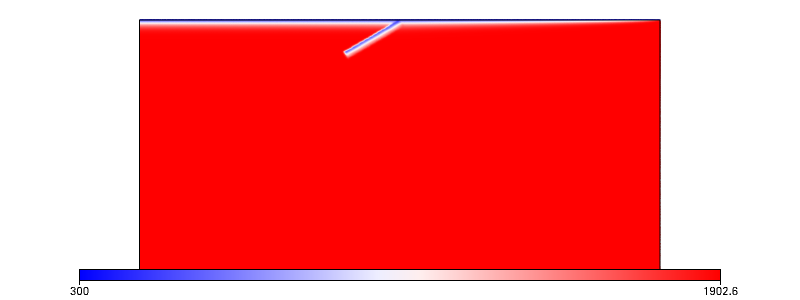

'freeslip_temp_final.png'

In [9]:
fig_res = (800,300)

Fig = vis.Figure(resolution=fig_res,rulers=False,margin = 20,rulerticks=7,quality=2,clipmap=False)
#Fig.Points(Model.Tip_tracers, pointSize=8.0)
cmap = vis.lavavu.matplotlib_colourmap("bwr")
Fig.Points(swarmCopy, temperatureField*2500.,discrete=False,fn_size=2.0,colourBar=True,colours=cmap)

# visc.colourbar(size=[0.95,15], align="bottom")
# cbar1.colourmap([(0, 'green'), (0.75, 'yellow'), (1, 'red')], reverse=True)
Fig.show()
Fig.save("freeslip_temp_final.png")

In [10]:
npoints = xRes*2+1
coords_wall = np.zeros((npoints,2))
coords_wall[:,0] = 0.
coords_wall[:,1] = np.linspace(ymin,ymax,npoints)
visc_wall = projViscosityField.evaluate(coords_wall)
temp_wall = temperatureField.evaluate(coords_wall) 
rho_wall = projDensityField.evaluate(coords_wall) 

(-200.0, 0.0)

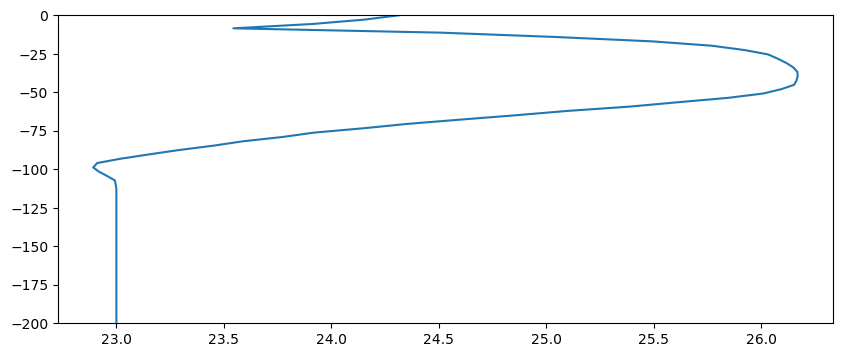

In [11]:
fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.plot(np.log10(dimen(visc_wall,u.pascal*u.second).m),coords_wall[:,1]/k_1km)
ax1.set_ylim([-200,0])

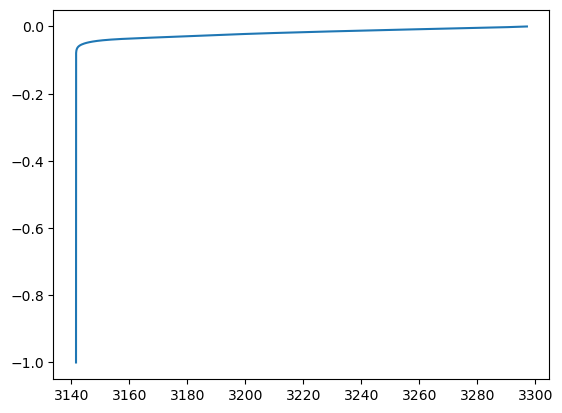

In [12]:
plt.plot(dimen(rho_wall,u.kilogram / u.meter**3).m,coords_wall[:,1])

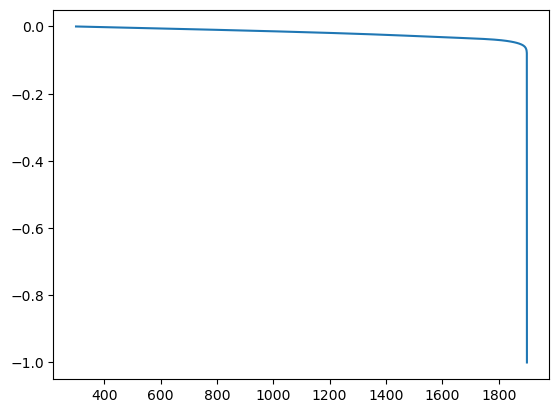

In [13]:
plt.plot(dimen(temp_wall,u.degK).m,coords_wall[:,1])

In [14]:
# step3 =  200

# #step1 = 0

# step = step3
# fdir = fdir3
# meshCopy = mesh1
# label = label1
# vscaling = 5e3
# gravity    = 9.81 * u.meter / u.second**2  

# meshCopy = load_mesh_uwg(fdir,meshCopy,step,remesh=True)
# topowall = mesh1.specialSets['Top_VertexSet']

# coords = meshCopy.data[topowall]
# xdis3, topo3 = coords[:,0],coords[:,1]

In [15]:
step2 =  200


step = step2
fdir = fdir2
meshCopy = mesh2
label = label2
vscaling = 5e3
gravity    = 9.81 * u.meter / u.second**2  

meshCopy = load_mesh_uwg(fdir,meshCopy,step,remesh=False)
surfswarmCopy = load_swarm_uwg(fdir,meshCopy,step,'Surface-')

coords = surfswarmCopy.data.copy()
xdis2, topo2 = coords[:,0],coords[:,1]

swarmCopy = load_swarm_uwg(fdir,meshCopy,step,'swarm-')
materialfiled = load_swarm_variable_uwg(fdir,swarmCopy,step,'materialField-','int',1)

swarmcoords = swarmCopy.data.copy()
materialindex = materialfiled.data.copy()

In [16]:
time = 2000
offset_y = 1.5

k_1ka = ndim(1*u.kiloyear)
k_1km = ndim(1*u.kilometer)

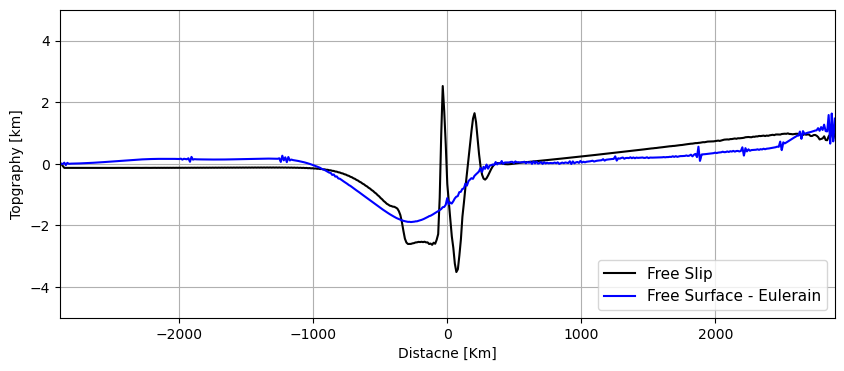

In [17]:
fname = f'topo_step{step1}_whole uwg_uw2'
fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 

ax1.plot(xdis1/k_1km,(topo1-topo1[0])/k_1km,"-k",label=label1) 
ax1.plot(xdis2/k_1km,(topo2-topo2[0])/k_1km,"-b",label=label2) 
#ax1.scatter(swarmcoords[:,0]/k_1km,swarmcoords[:,1]/k_1km,c = materialindex,s=2)

#ax1.plot(xdis3/k_1km,(topo3-topo3[0])/k_1km,"-r",label=label3) 

ax1.legend()
ax1.annotate('Time = {} Ma'.format(time/1000),[100,-9])
#ax1.annotate('Time = {} Ma'.format(time3/1000),[100,5.5])
#ax1.scatter(x_
ax1.set_xlim([-2890,2890])
ax1.set_ylim([-5,5])
ax1.grid()
#ax1.legend()
ax1.legend(loc = 'lower right',prop = {'size':11})
plt.savefig(fname,dpi=150,bbox_inches='tight')

In [18]:
offset_y = 0

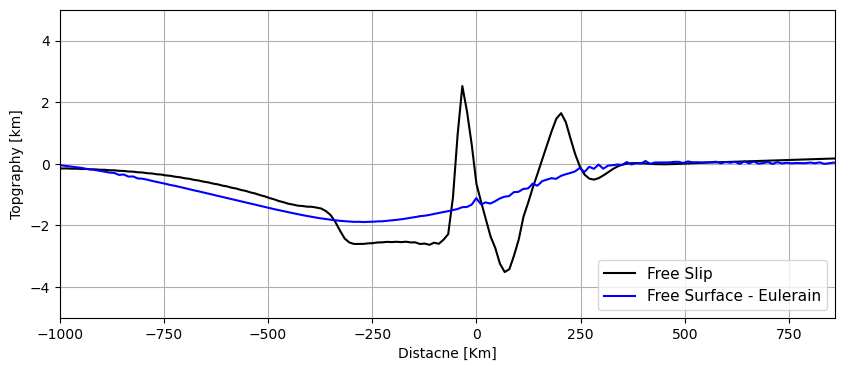

In [19]:
fname = f'topo_step{step1}_uwg_uw2'
fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 

ax1.plot(xdis1/k_1km,(topo1-topo1[0])/k_1km+offset_y,"-k",label=label1) 
ax1.plot(xdis2/k_1km,(topo2-topo2[0])/k_1km,"-b",label=label2) 
#ax1.scatter(swarmcoords[:,0]/k_1km,swarmcoords[:,1]/k_1km,c = materialindex,s=2)

#ax1.plot(xdis3/k_1km,(topo3-topo3[0])/k_1km,"-r",label=label3) 

ax1.legend()
ax1.annotate('Time = {} Ma'.format(time/1000),[100,-9])
#ax1.annotate('Time = {} Ma'.format(time3/1000),[100,5.5])
#ax1.scatter(x_
#ax1.set_xlim([-500,300])
ax1.set_xlim([1890-2890,3750-2890])
ax1.set_ylim([-5,5])
ax1.grid()
#ax1.legend()
ax1.legend(loc = 'lower right',prop = {'size':11})
plt.savefig(fname,dpi=150,bbox_inches='tight')

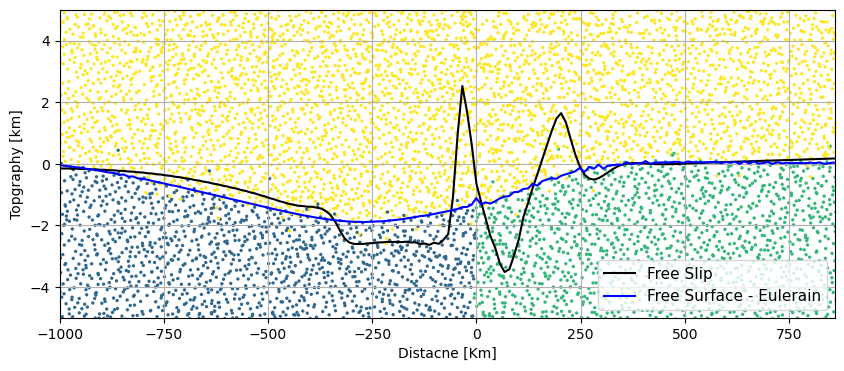

In [20]:
fname = f'topo_step{step1}_uwg_uw2_2'
fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 

ax1.plot(xdis1/k_1km,(topo1-topo1[0])/k_1km+offset_y,"-k",label=label1) 
ax1.plot(xdis2/k_1km,(topo2-topo2[0])/k_1km,"-b",label=label2) 
ax1.scatter(swarmcoords[:,0]/k_1km,swarmcoords[:,1]/k_1km,c = materialindex,s=2)

#ax1.plot(xdis3/k_1km,(topo3-topo3[0])/k_1km,"-r",label=label3) 

ax1.legend()
ax1.annotate('Time = {} Ma'.format(time/1000),[100,-9])
#ax1.annotate('Time = {} Ma'.format(time3/1000),[100,5.5])
#ax1.scatter(x_
#ax1.set_xlim([-500,300])
ax1.set_xlim([1890-2890,3750-2890])
ax1.set_ylim([-5,5])
ax1.grid()
#ax1.legend()
ax1.legend(loc = 'lower right',prop = {'size':11})
plt.savefig(fname,dpi=150,bbox_inches='tight')

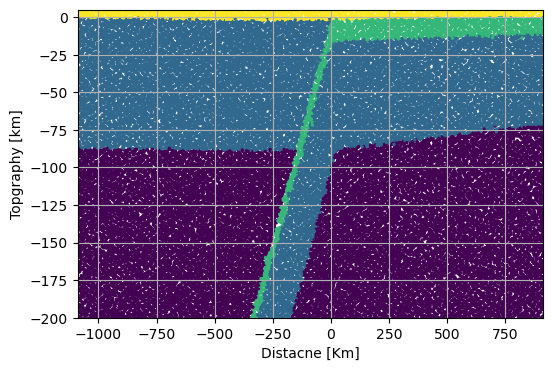

In [16]:
fname = f'topo_step{step1}_uwg_uw2'
fig, ax1 = plt.subplots(nrows=1, figsize=(6,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
 
ax1.scatter(swarmcoords[:,0]/k_1km,swarmcoords[:,1]/k_1km,c = materialindex,s=2)
 
#ax1.legend()
#ax1.annotate('Time = {} Ma'.format(time/1000),[100,-9])
#ax1.annotate('Time = {} Ma'.format(time3/1000),[100,5.5])
#ax1.scatter(x_
ax1.set_xlim([1800-2890,3800-2890])
ax1.set_ylim([-200,5])
ax1.grid()
#ax1.legend()
#ax1.legend(loc = 'lower right',prop = {'size':11})
plt.savefig(fname,dpi=150,bbox_inches='tight')

In [14]:
swarmcoords[:,0]/k_1km

array([-2882.77696672, -2886.38848564, -2879.16544326, ...,   751.88166667,
        2241.195     ,  -427.23833333])

In [ ]:
from underworld import visualisation as vis
fig_res = (800,300)


Fig = vis.Figure(resolution=fig_res,rulers=False,margin = 20,rulerticks=7,quality=2,clipmap=False)
#Fig.Points(Model.Tip_tracers, pointSize=8.0)

cmap = vis.lavavu.matplotlib_colourmap("RdYlBu_r")
Fig.Points(swarmCopy, fn.math.log10(projViscosityField*refViscosity.m),discrete=False,fn_size=2.0,colourBar=True,colours=cmap)
# visc.colourbar(size=[0.95,15], align="bottom")
# cbar1.colourmap([(0, 'green'), (0.75, 'yellow'), (1, 'red')], reverse=True)
Fig.show()
Fig.save("Modelsetup_visc.png")

In [ ]:
plt.imshow(projViscosityField.data.reshape(yRes+1,xRes+1))

In [1]:
2890/200

14.45